## Resources
- Tiktokenizer
- Andrej Karpathy (Youtube) https://www.youtube.com/watch?v=7xTGNNLPyMI

In [ ]:
!pip install transformers accelerate bitsandbytes pandas timm

In [1]:
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import timm # Provides lots of pretrained models for image classification
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


## 1. Create a Dataset class for the data loader

In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [3]:
data_directory = './card-dataset'
dataset = PlayingCardDataset(data_dir=data_directory)

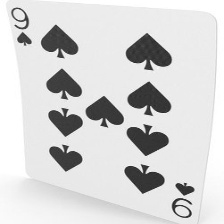

In [4]:
# Some output from our dataset just for example's sake
image, label = dataset[4356]
image

In [5]:
train_dir = "./card-dataset/train"
test_dir = "./card-dataset/test"
valid_dir = "./card-dataset/valid"

In [6]:
# Cards and their labels
target_to_class = {v: k for k, v in ImageFolder(train_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

## 2. Make the input Uniform

In [7]:
# Recreate the dataset while transforming every image into a consistent shape
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
# dataset = PlayingCardDataset(data_directory, transform)
train_dataset = PlayingCardDataset(train_dir, transform)
valid_dataset = PlayingCardDataset(valid_dir, transform)
test_dataset = PlayingCardDataset(test_dir, transform)

In [8]:
# Now we can analyze our data according to how PyTorch sees it
image, label = train_dataset[100]
image

tensor([[[0.0000, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0078, 0.0431,  ..., 0.0196, 0.0039, 0.0078],
         [0.0235, 0.0392, 0.3490,  ..., 0.2392, 0.0314, 0.0118],
         ...,
         [0.0039, 0.0235, 0.2392,  ..., 0.2196, 0.0314, 0.0118],
         [0.0039, 0.0039, 0.0235,  ..., 0.0118, 0.0078, 0.0039],
         [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0392,  ..., 0.0196, 0.0039, 0.0078],
         [0.0078, 0.0275, 0.3373,  ..., 0.2392, 0.0275, 0.0078],
         ...,
         [0.0039, 0.0235, 0.2431,  ..., 0.2196, 0.0314, 0.0078],
         [0.0039, 0.0039, 0.0235,  ..., 0.0157, 0.0078, 0.0039],
         [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0039]],

        [[0.0196, 0.0196, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0078, 0.0353,  ..., 0.0157, 0.0039, 0.0078],
         [0.0118, 0.0196, 0.3137,  ..., 0.2196, 0.0235, 0.

In [9]:
# A 3D tensor describing its shape. "3" for each color channel
image.shape

torch.Size([3, 128, 128])

# 3. DataLoader

In [10]:
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Reminder that datasets are iterablee
for images, labels in train_loader:
    break

# 4. PyTorch Model

It's important to understand the shapes of each layer of the model you're using, and how that affects the output

In [12]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
    def forward(self, examples): # this is an override from the nn.Module class, called during any model(input), and makes sure you won't overwrite the @call method
        examples = self.features(examples)
        output = self.classifier(examples)
        return output

In [13]:
model = SimpleCardClassifier(num_classes=53)

In [14]:
print(str(model)[:500] + "\n...")

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa
...


In [15]:
example = model(images)
example.shape # [batch_size, num_classes]

torch.Size([32, 53])

# 5. Training the Model

This is an extremely simple example

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
criterion(example, labels)

tensor(3.9985, grad_fn=<NllLossBackward0>)

# 6. Training Loop

In [18]:
# Add the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
num_epochs = 5
train_losses, val_losses = [], []
model = SimpleCardClassifier(num_classes=53)
model.to(device)

for epoch in range(num_epochs):
    # Set the model to train
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images) # calls nn.Module.forward()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase of the loop
    model.eval()
    running_loss = 0.0 # reset loss
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    # Epoch results
    print(f"[Epoch {epoch+1}/{num_epochs}]\nTrain Loss: {train_loss}\nValidation Loss: {val_loss}")
        
    

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 1/5]
Train Loss: 4.016450215987119
Validation Loss: 4.007015985812781


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 2/5]
Train Loss: 4.013586063575144
Validation Loss: 4.006502155088029


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 3/5]
Train Loss: 4.014284504673288
Validation Loss: 4.011342109824127


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 4/5]
Train Loss: 4.012659188958055
Validation Loss: 4.009809753130067


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 5/5]
Train Loss: 4.013316509981346
Validation Loss: 4.006664279721818
